In [104]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../")

import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of metal.end_model.end_model failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ImportError: cannot import name 'MTClassifier'
]


In [107]:
from  metal.utils import hard_to_soft

N = 1200
X = np.random.random((N,100)) * 2 - 1

Y = np.zeros((N,1))
Y[:,0] = (X[:,0] > X[:,1] + 0.5).astype(int) + 1

X = torch.tensor(X, dtype=torch.float)
Y = torch.tensor(Y, dtype=torch.long)

X_train = X[:1000]
X_dev   = X[1000:1100]
X_test  = X[1100:]

Y_train = Y[:1000, 0]
Y_dev   = Y[1000:1100]
Y_test  = Y[1100:, 0]

In [108]:
rs_max_search = 50

search_space = {
    'n_epochs': [10, 20, 50, 100, 200, 300],
    'batchnorm' : [True, False],
    'dropout': [0, .1, .2, .3, .4, .5],
    'lr': {'range': [1e-5, 1], 'scale': 'log'},
    'print_every': 50
}

In [109]:
# First run basic grid search / random search
from metal.label_model import LabelModel
from metal.end_model import EndModel
from metal.tuner import ModelTuner

def run_random_search(seed=123):
    tuner = ModelTuner(EndModel)
    init_args = []
    train_args = [X_train, Y_train]
    model, best_config, run_stats_random_search = tuner.search(init_args, train_args, X_dev, Y_dev, 
                                                               search_space, max_search=rs_max_search, metric='f1')
    return run_stats_random_search

In [110]:

# Hyperband
from metal.label_model import LabelModel
from metal.end_model import EndModel
from metal.tuner import HyperbandTuner

def run_hyperband(seed=123):    
    tuner = HyperbandTuner(EndModel, hyperband_epochs_budget=2000, seed=seed)
    init_args = []
    train_args = [X_train, Y_train]

    model, best_config, run_stats_hyperband = tuner.search(init_args, train_args, X_dev, Y_dev, 
                                                           search_space)
    return run_stats_hyperband

In [ ]:
#%%capture
#seeds = [123, 234, 456, 567, 678]
seeds = [123]
runstats_hyperband = []
runstats_rs = []
for seed in seeds:
    runstats_rs.append(run_random_search(seed=seed))
    runstats_hyperband.append(run_hyperband(seed=seed))
    
print(runstats_hyperband)
print(runstats_rs)

|           Hyperband Schedule          |
Table consists of tuples of (num configs, num_resources_per_config) which specify how many configs to run and for how many epochs. 
Each bracket starts with a list of random configurations which is successively halved according the schedule.
See the Hyperband paper (https://arxiv.org/pdf/1603.06560.pdf) for more details.
-----------------------------------------
Bracket 0: (81, 1) (27, 3) (9, 10) (3, 32) (1, 98)
Bracket 1: (27, 3) (9, 10) (3, 32) (1, 97)
Bracket 2: (9, 10) (3, 32) (1, 97)
Bracket 3: (6, 32) (2, 98)
Bracket 4: (5, 98)
-----------------------------------------

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=100, out_features=50, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4)
  )
  (2): Linear(in_features=50, out_features=2, bias=True)
)

[0 Testing {'n_epochs': 1, 'batchnorm': True

/usr/local/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Saving model at iteration 0 with best score 0.88
[E:0]	Train Loss: 0.507	Dev score: 0.880
Restoring best model from iteration 0 with score 0.88
Finished Training
Confusion Matrix (Dev)
        y=1    y=2   
 l=1    75      7    
 l=2     3     15    
Accuracy: 0.860

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=100, out_features=50, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3)
  )
  (2): Linear(in_features=50, out_features=2, bias=True)
)

[2 Testing {'n_epochs': 1, 'batchnorm': False, 'dropout': 0.3, 'lr': 0.004318916033929973}
Saving model at iteration 0 with best score 0.79
[E:0]	Train Loss: 0.548	Dev score: 0.790
Restoring best model from iteration 0 with score 0.79
Finished Training
Confusion Matrix (Dev)
        y=1    y=2   
 l=1    78     21    
 l=2     0      1    
Accuracy: 0.780

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=100, out_features=50, bias

[[{'time_elapsed': 0.04473710060119629, 'best_score': 0.653968253968254}, {'time_elapsed': 0.08689212799072266, 'best_score': 0.6588235294117647}, {'time_elapsed': 0.15291810035705566, 'best_score': 0.6696562032884903}, {'time_elapsed': 0.3547940254211426, 'best_score': 0.6740506329113924}, {'time_elapsed': 3.3674659729003906, 'best_score': 0.6740858505564387}, {'time_elapsed': 3.3971080780029297, 'best_score': 0.6813880126182965}]]


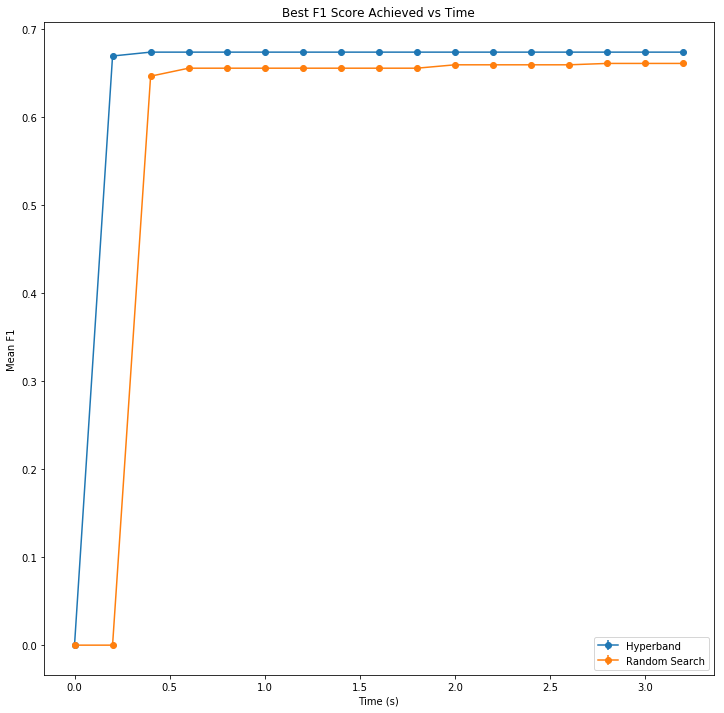

In [23]:
%matplotlib inline

# Plot random search vs hyperband run stats
import matplotlib.pyplot as plt
import matplotlib as mpl

print(runstats_hyperband)

xs_hyperband = [[x["time_elapsed"] for x in z] for z in runstats_hyperband]
ys_hyperband = [[x["best_score"] for x in z] for z in runstats_hyperband]
xs_rs = [[x["time_elapsed"] for x in z] for z in runstats_rs]
ys_rs = [[x["best_score"] for x in z] for z in runstats_rs]

# Extract min and max times for segmented times
flat_xs_hyperband = [item for sublist in xs_hyperband for item in sublist]
flat_xs_rs = [item for sublist in xs_rs for item in sublist]
min_time, max_time = 0, max(flat_xs_hyperband + flat_xs_rs)


# Get list of best scores at time
def get_best_scores_at_time(all_runstats, target_time):
    best_scores = []
    for runstats in all_runstats:
        best_score = 0        
        times = [x["time_elapsed"] for x in runstats]
        scores = [x["best_score"] for x in runstats]
        for time, score in zip(times, scores):
            if time < target_time:
                best_score = score
        best_scores.append(best_score)
    return best_scores
        
# Extract best scores per segment
segments = list(np.arange(0, max_time, .2))
hyperband_scores = [get_best_scores_at_time(runstats_hyperband, t) for t in segments]
rs_scores = [get_best_scores_at_time(runstats_rs, t) for t in segments]

# Extract means and error bars
mean_hyperband_scores = [np.mean(x) for x in hyperband_scores]
mean_rs_scores = [np.mean(x) for x in rs_scores]
hyperband_stds = [np.std(x) for x in hyperband_scores]
rs_stds = [np.std(x) for x in rs_scores]

#plt.plot(segments, mean_hyperband_scores, label="Hyperband", marker="o")
#plt.plot(segments, mean_rs_scores, label="Random Search", marker="o")
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.errorbar(segments, mean_hyperband_scores, hyperband_stds, label="Hyperband", marker="o")
plt.errorbar(segments, mean_rs_scores, rs_stds, label="Random Search", marker="o")
plt.legend(loc="best")
plt.title("Best F1 Score Achieved vs Time")
plt.xlabel("Time (s)")
plt.ylabel("Mean F1")